In [9]:
!git clone https://github.com/Prashant-AV/Qualcomm-DL-Hackathon/

Cloning into 'Qualcomm-DL-Hackathon'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 30.68 MiB | 28.07 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [11]:
!unzip "/content/Qualcomm-DL-Hackathon/train/images part-1.zip" -d "/content/Qualcomm-DL-Hackathon/train/" > /dev/null
!unzip "/content/Qualcomm-DL-Hackathon/train/images part-2.zip" -d "/content/Qualcomm-DL-Hackathon/train/" > /dev/null

replace /content/Qualcomm-DL-Hackathon/train/images part-1/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace /content/Qualcomm-DL-Hackathon/train/images part-2/1201.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import pandas as pd
import os


## name of folders are changed


if not os.path.exists("/content/Qualcomm-DL-Hackathon/train/images_part-1"):
  os.rename(r"/content/Qualcomm-DL-Hackathon/train/images part-1","/content/Qualcomm-DL-Hackathon/train/images_part-1")
if not os.path.exists("/content/Qualcomm-DL-Hackathon/train/images_part-2"):
  os.rename(r"/content/Qualcomm-DL-Hackathon/train/images part-2","/content/Qualcomm-DL-Hackathon/train/images_part-2")

train_csv = r"./Qualcomm-DL-Hackathon/train/train.csv" #"/content/Qualcomm-DL-Hackathon/train/train.csv"
df = pd.read_csv(train_csv)
df.head()

im_pt_1 =  r"./Qualcomm-DL-Hackathon/train/images_part-1" #"/content/Qualcomm-DL-Hackathon/train/images_part-1"
base,_,images = next(os.walk(im_pt_1))

images_path = list(map(lambda im : os.path.join(base,im),images))


im_pt_2 = r"./Qualcomm-DL-Hackathon/train/images_part-2" #"/content/Qualcomm-DL-Hackathon/train/images_part-2"
base,_,images2 = next(os.walk(im_pt_2))

images2_path = list(map(lambda im : os.path.join(base,im),images2))

images.extend(images2)
images_path.extend(images2_path)

image_path_lookup = dict(zip(images,images_path))

paths = []
for r in df.iterrows():
  im = r[1].iloc[0]
  pth = image_path_lookup.get(im,None)
  #print(im,pth)
  if not pth:
    print(im)
  paths.append(pth)

df["paths"] = paths

#len(image_path_lookup)
df["emergency_or_not"].value_counts()



,count
emergency_or_not,
0,965
1,681


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image = Image.open(r"./Qualcomm-DL-Hackathon/train/images_part-2/1503.jpg")
image.size

(224, 224)

In [4]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):

        self.image_paths = dataframe["paths"].to_list()
        self.labels = dataframe["emergency_or_not"].to_list()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image,float(label)



In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform = transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = CustomImageDataset(df, transform=transform)
batch_size = 15
validation_split = 0.3
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [ ]:
len(val_indices)

493

torch.Size([15, 3, 224, 224])
tensor(1., dtype=torch.float64)


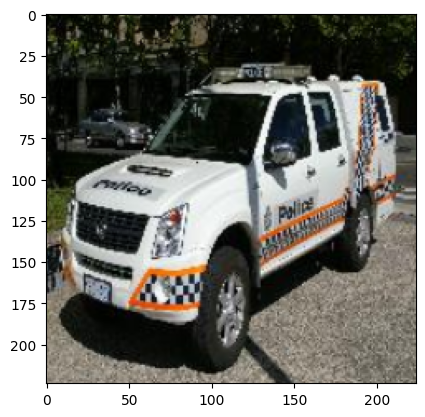

In [11]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))
print(images.size())
print(labels[0])
imshow(images[0])

In [12]:

import torch.nn as nn
import torch.nn.functional as F
import torch

hidden_layer1 = 10
hidden_layer2 = 25
hidden_layer3 = 30
hidden_layer4 = 10

#x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, hidden_layer1, 3)
        self.conv1_bn = nn.BatchNorm2d(hidden_layer1)
        self.pool = nn.MaxPool2d(2, 2) ## dim are hidden_layer_1 * (224 - 2) / 2)
        self.conv2 = nn.Conv2d(hidden_layer1,hidden_layer2, 5)
        self.conv2_bn = nn.BatchNorm2d(hidden_layer2) ## dim are hidden_layer_2 * (111 - 4) / 2)
        self.fc1 = nn.Linear(hidden_layer2 * 53 * 53, hidden_layer3)
        self.fc2 = nn.Linear(hidden_layer3, hidden_layer4)
        self.fc3 = nn.Linear(hidden_layer4, 1)
        self.float()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x.squeeze(1)


net = Net()

In [13]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0001,weight_decay=1e-2)

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.type(torch.DoubleTensor)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).type(torch.DoubleTensor)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print(loss.item())
        # print statistics
        running_loss += loss.item()
        if i > 0 and i % 10 == 9:    # print every 5 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/10:.3f}')
            running_loss = 0.0


print('Finished Training')

[1,    10] loss: 0.652
[1,    20] loss: 0.581
[1,    30] loss: 0.602
[1,    40] loss: 0.550
[1,    50] loss: 0.529
[1,    60] loss: 0.511
[1,    70] loss: 0.486
[2,    10] loss: 0.385
[2,    20] loss: 0.326
[2,    30] loss: 0.331
[2,    40] loss: 0.368
[2,    50] loss: 0.492
[2,    60] loss: 0.451
[2,    70] loss: 0.354
[3,    10] loss: 0.278
[3,    20] loss: 0.253
[3,    30] loss: 0.274
[3,    40] loss: 0.284
[3,    50] loss: 0.356
[3,    60] loss: 0.317
[3,    70] loss: 0.261
Finished Training


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        labels = labels.type(torch.IntTensor)
        # calculate outputs by running images through the network
        outputs = net(images)
        #print(labels,outputs)
        predicted = torch.round(outputs).type(torch.IntTensor)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(labels,predicted)


print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')



Accuracy of the network on the 493 test images: 81 %


In [25]:
images,output = data
outs = [(a.item(),b.item()) for a,b in zip(outputs,output)]

for o in outs:
  print(o)

(0.07380899041891098, 1.0)
(0.30095067620277405, 0.0)
(0.11133663356304169, 1.0)
(0.5302753448486328, 1.0)
(0.14401093125343323, 1.0)
(0.017007529735565186, 0.0)
(0.330933153629303, 0.0)
(0.843508780002594, 1.0)
(0.981999397277832, 1.0)
(0.6558197736740112, 1.0)
(0.4517015516757965, 0.0)
(0.41103649139404297, 0.0)
(0.29964563250541687, 1.0)


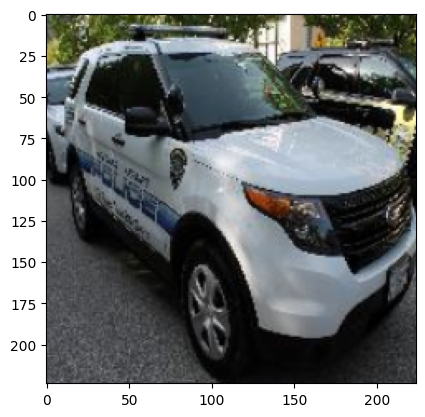

0 1


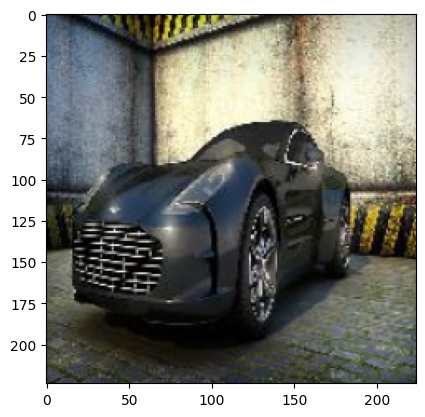

0 0


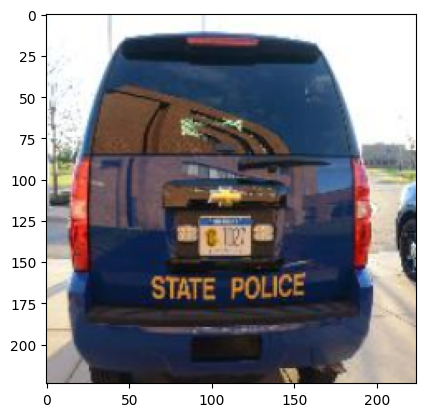

0 1


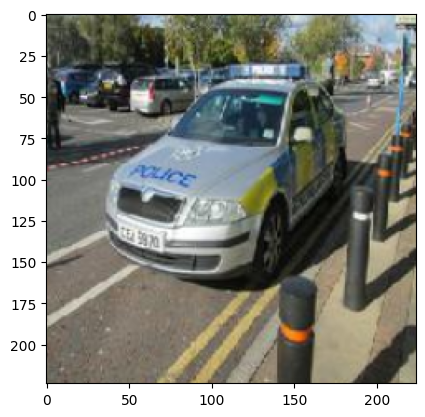

1 1


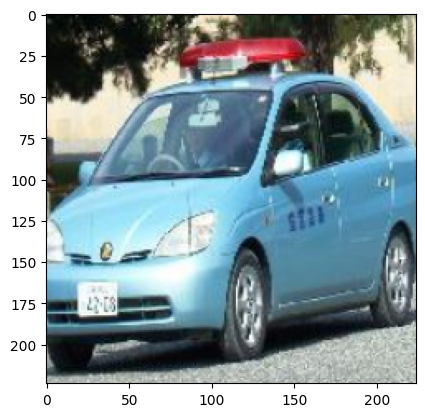

0 1


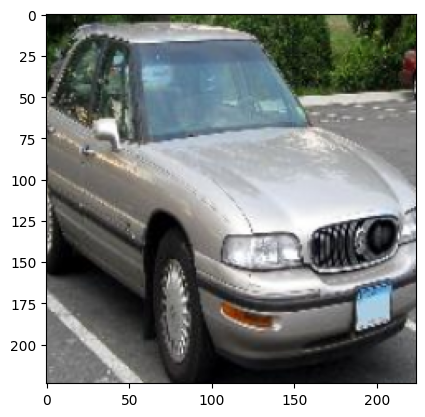

0 0


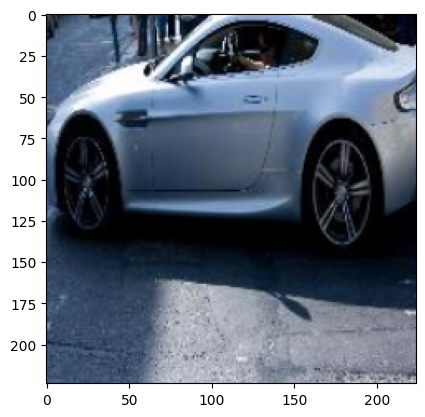

0 0


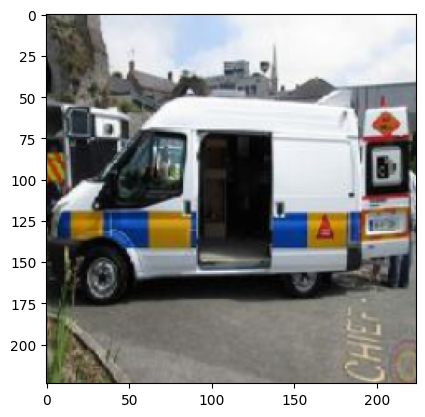

1 1


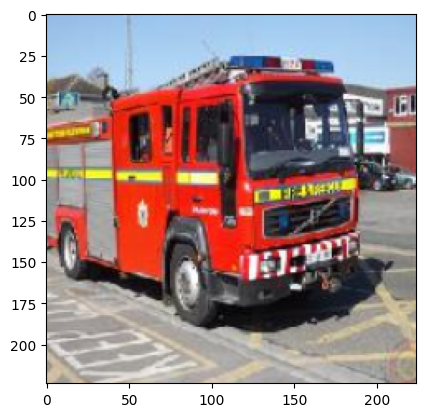

1 1


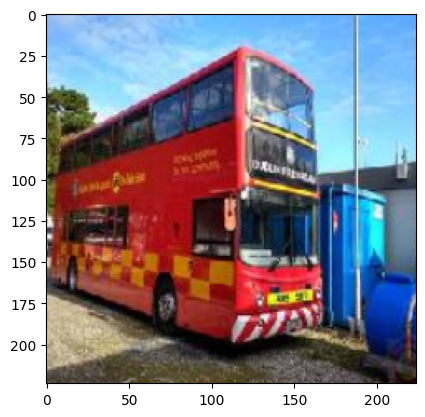

1 1


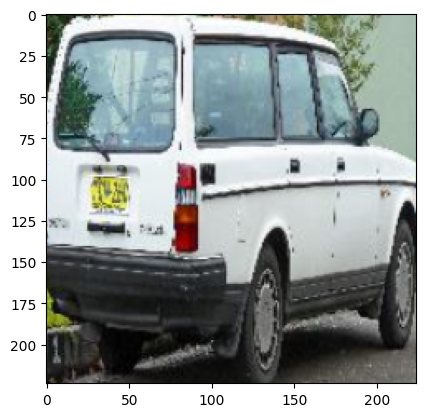

0 0


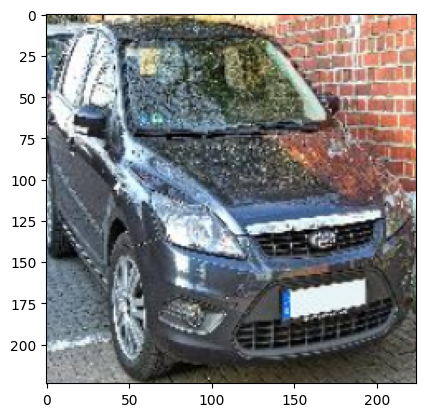

0 0


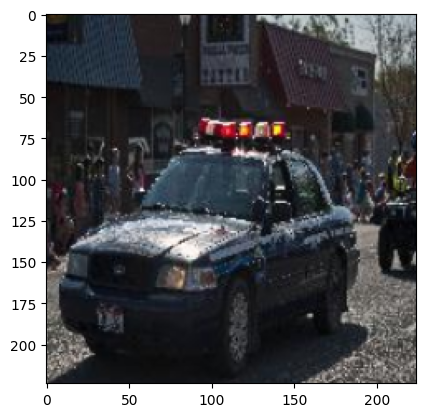

0 1


In [35]:
for (im,p,o) in zip(images,outputs,output):
  imshow(im)
  print(torch.round(p).type(torch.IntTensor).item() , o.type(torch.IntTensor).item())